<a href="https://colab.research.google.com/github/RicardxJMG/Simple-Robot-Trading/blob/main/Robot_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Configuración del ambiente**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from bs4 import BeautifulSoup
# from datetime import date, timedelta

In [ ]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

# **2. Obtención de los datos**

## **2.1 Precios Historicos del Bitcoin**

Se cargarán los precios (en dólares ) históricos del Bitcoin en de los últimos 7 días en un intervalo de 5 minutos.

In [ ]:
def importar_base_bitcoin():
  global df_bitcoin
  #Obteniendo datos historicos del Bitcoin
  df_bitcoin = yf.download('BTC-USD', period= '7d', interval='5m')

In [ ]:
importar_base_bitcoin()
df_bitcoin.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-03-22 00:00:00+00:00,65492.078125,65499.984375,65470.269531,65499.984375,65499.984375,0
2024-03-22 00:05:00+00:00,65518.980469,65747.351562,65518.980469,65747.351562,65747.351562,9822208
2024-03-22 00:10:00+00:00,65762.164062,65784.195312,65721.835938,65774.515625,65774.515625,0
2024-03-22 00:15:00+00:00,65778.320312,65874.304688,65770.875000,65874.304688,65874.304688,0
2024-03-22 00:20:00+00:00,65928.281250,65928.281250,65847.648438,65852.742188,65852.742188,4698112


Para entender mejor el contenido del dataframe:
* **Datetime:** Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.
* **Open:** Contiene el precio del Bitcoin al inicio del intervalo.
* **High:** Contiene el precio más alto del Bitcoin durante el intervalo.
* **Low:** Contiene el precio más bajo del Bitcoin durante el intervalo.
* **Close:** Contiene el precio del Bitcoin al final del intervalo.
* **Volume:** Contiene el total de transacciones hechas durante el intervalo.



## **2.2 Extrayendo precio actual y tendencia del Bitcoin.**

In [ ]:
def extraer_tendencias():
  global precio_actual, tendencia
  url = 'https://coinmarketcap.com/'
  respuesta = requests.get(url)

  #Verificando que la busquedad fue un exito
  if respuesta.status_code == 200:
    s = BeautifulSoup(respuesta.content, 'lxml')

    #Obteniendo los span de la primera fila de la tabla de coinmarketcap.com
    html_row = s.findAll("tr")
    html_row = html_row[1]
    elementos = html_row.findAll("span")

    #Obteniendo el precio actual del Bitcoin en USD
    precio_actual = float(elementos[2].text.replace('$', '').replace(',',''))

    #Obteniendo  la tendencia
    if elementos[3].next.attrs['class'][0] == "icon-Caret-up":
      tendencia = 'Alta'
    else:
      tendencia = 'Baja'

  else:
    print("Error al cargar la página de CoinMarketCap")

In [ ]:
extraer_tendencias()
print(f'Precio Actual: ${precio_actual} USD')
print(f'Tendencia: {tendencia}')

Precio Actual: $70699.3 USD
Tendencia: Baja


# **3. Limpieza de datos**

## **3.1 Análisis antes de la limpieza de datos**

In [ ]:
# Creando copia del dataframe bitcoin
global df_bitcoin_limpio
df_bitcoin.drop('Adj Close', axis =1, inplace=True)
df_bitcoin_limpio = df_bitcoin.copy()

La siguiente función imprime la siguiente informacion del dataframe original: La cantidad de registros duplicados, si existen valores nulos en la columna *close* y cuenta el total de registros cuyo *Volume* no es mayor a cero, i.e, aquellos registros en que no se hizo ninguna transacción.

In [ ]:
def analisis():
  global df_bitcoin_limpio
  indices_repetidos = df_bitcoin_limpio.duplicated().sum()
  valores_nulos_close = 'Si' if df_bitcoin_limpio.Close.isna().any() == True else "No"
  registros_cero = df_bitcoin_limpio.Volume[df_bitcoin_limpio.Volume <= 0].count()

  print(f'Existen {indices_repetidos} indices repetidos.')
  print(f'Existen valores nulos en la columna "Close": {valores_nulos_close}')
  print(f'Registros que tengan registros Volume de transacción menor o igual a cero: {registros_cero}')
analisis()

Existen 0 indices repetidos.
Existen valores nulos en la columna "Close": No
Registros que tengan registros Volume de transacción menor o igual a cero: 1061


In [ ]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1998 entries, 2024-03-22 00:00:00+00:00 to 2024-03-28 22:25:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1998 non-null   float64
 1   High    1998 non-null   float64
 2   Low     1998 non-null   float64
 3   Close   1998 non-null   float64
 4   Volume  1998 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 93.7 KB


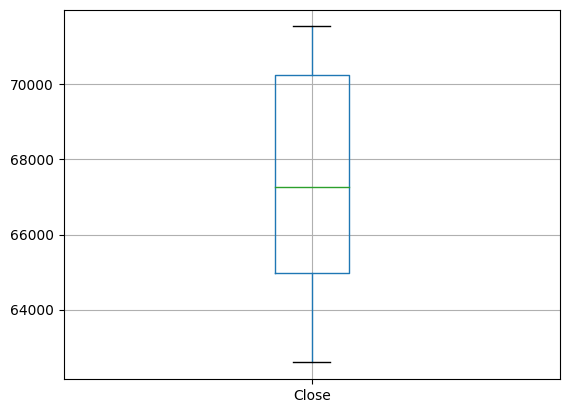

In [ ]:
df_bitcoin_limpio.boxplot('Close');

## **3.2 Creación de la función que limpia la base de datos**

De la copia del dataframe, se realizará la siguienete limpieza:
1. Los valores duplicados serán eliminados, encaso de existir.
2. En la columna que almacena los precios de cierre, en caso de que el valor sea nulo, este será llenado con el valor anterior que no lo es.
3. Serán elimindaos aquellos registros cuyo volume de transacción no sean mayores a cero.
4. Nos concentraremos en aquellos registros cuyos precios de cierre se encuentren entre los quartiles $Q_1,\ Q_3$.

In [ ]:
def limpieza_datos():
  global df_bitcoin, media_bitcoin, df_bitcoin_limpio
  #Creando una copia del dataframe original
  df_bitcoin_limpio = df_bitcoin.copy()

  # Eliminando valores respetidos del dataframe en caso de existir
  df_bitcoin_limpio.drop_duplicates(inplace=True)

  # Tratando los valores nulos de la columna close
  valores_nulos = df_bitcoin_limpio.Close.isna().any()
  if valores_nulos == True:
    df_bitcoin_limpio.Close.fillna(method='ffill', inplace=True)

  # Eliminado registros que tengan un Volume de transaccion igual cero
  query = df_bitcoin_limpio.query('Volume <= 0').index
  df_bitcoin_limpio.drop(query, axis = 0, inplace = True)

  # Seleccionado registro de la columna Close que esten entre Q1 y Q3
  Q1 = df_bitcoin_limpio.Close.quantile(0.25)
  Q3 = df_bitcoin_limpio.Close.quantile(0.75)
  # IIQ = Q3-Q1
  df_bitcoin_limpio = df_bitcoin_limpio.query(f'Close > {Q1} & Close < {Q3}')

  # Calculando la media con los datos ya filtrados.
  media_bitcoin = df_bitcoin_limpio.Close.mean()
  df_bitcoin

In [ ]:
limpieza_datos()
analisis()
print(f'\nEl promedio del precio de Bitcoin es: {round(media_bitcoin,2)}')

Existen 0 indices repetidos.
Existen valores nulos en la columna "Close": No
Registros que tengan registros Volume de transacción menor o igual a cero: 0

El promedio del precio de Bitcoin es: 68159.49


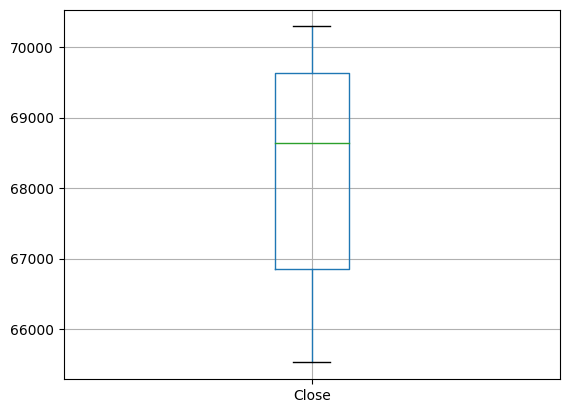

In [ ]:
df_bitcoin_limpio.boxplot('Close');

# **4. Toma de decisiones**

In [ ]:
def tomar_decision():
  global algoritmo_decision, tendencia, media_bitcoin, precio_actual

  if precio_actual >= media_bitcoin and tendencia == 'Baja':
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'Alta':
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

In [ ]:
tomar_decision()

# **5. Visualización**

In [ ]:
def visualizacion():
  global df_bitcoin, media_bitcoin, algoritmo_decision
  # Añadiendo una nueva columna
  df_bitcoin['Promedio'] = media_bitcoin

  # Configuración del gráfico
  #plt.style.use("dark_background")
  plt.figure(figsize=(16,5))
  plt.title('Precio cierre del Bitcoin en los últimos 7 días')
  plt.plot(df_bitcoin.index, df_bitcoin.Close, linewidth = 0.85, color = 'black');
  plt.plot(df_bitcoin.index, df_bitcoin.Promedio, color = 'orange', linestyle = '--');
  plt.legend(['Precio cierre del Bitcoin', 'Promedio'])

  color = 'green' if algoritmo_decision == 'Vender' else 'blue' if algoritmo_decision == 'Comprar' else 'red'
  plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin.Close[-1]), xytext=(df_bitcoin.index[-1], df_bitcoin.Close[-1]-1500),
             arrowprops=dict(facecolor=color, shrink=.1, width = 3, headwidth = 8), horizontalalignment='center')
  plt.show()


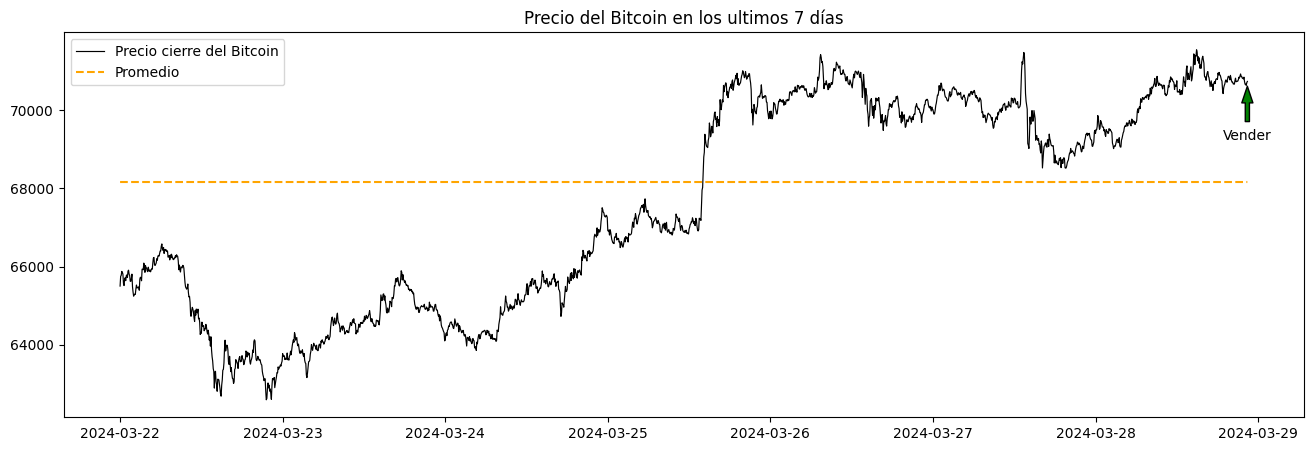

In [ ]:
visualizacion()

## **6. Automatización**

In [ ]:
from IPython.display import clear_output
import time

[*********************100%%**********************]  1 of 1 completed


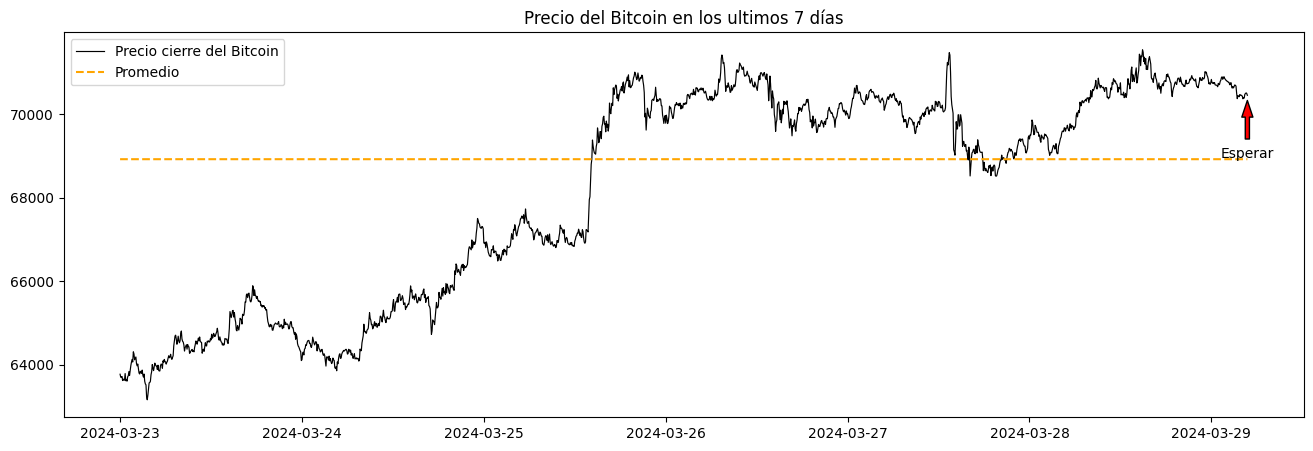

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decision()
  visualizacion()
  time.sleep(300)